# Receding Horizon

This notebook is your playground to pull together techniques from the previous lessons! A solution here can be built from previous solutions (more or less) so we will offer no solution notebook this time.

Here's a suggested approach:

1. Load the colliders data
2. Discretize your search space into a grid or graph
3. Define a start and goal location
4. Find a coarse 2D plan from start to goal
5. Choose a location along that plan and discretize
   a local volume around that location (for example, you
   might try a 40x40 m area that is 10 m high discretized
   into 1m^3 voxels)
6. Define your goal in the local volume to a a node or voxel
   at the edge of the volume in the direction of the next
   waypoint in your coarse global plan.
7. Plan a path through your 3D grid or graph to that node
   or voxel at the edge of the local volume.  

We'll import some of the routines from previous exercises that you might find useful here.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx
nx.__version__

# Grid creation routine
from grid import create_grid_and_edges, check_edge, create_edges_3d
# Voxel map creation routine
from voxmap import create_voxmap, create_voxmap_around_point, create_voxmap_around_point

# 2D A* planning routine (can you convert to 3D??)
from planning import a_star_graph, closest_point 
# path pruning
from pruning import prune_path

%matplotlib inline


plot_images = True


In [2]:
plt.rcParams['figure.figsize'] = 12, 12

## 1. Load the colliders data

In [3]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

xmin = np.min(data[:,0] - data[:,3]) 
xmax = np.max(data[:,0] + data[:,3]) 
ymin = np.min(data[:,1] - data[:,4]) 
ymax = np.max(data[:,1] + data[:,4]) 
zmin = 0
zmax = 20


[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


## 2. Discretize search space into a grid and then graph

In [4]:
flight_altitude = 3
safety_distance = 3
grid, edges = create_grid_and_edges(data, flight_altitude, safety_distance)

In [5]:
g = nx.Graph()
for e in edges:
    p1 = e[0]
    p2 = e[1]
    w = np.linalg.norm(np.array(p2) - np.array(p1))
    g.add_edge(p1, p2, weight=w)

## 3. Define a start and goal location

In [6]:
start_exact = (25,  100)
goal_exact = (750., 370.)

## 4. Find a coarse 2D plan from start to goal

In [7]:
def heuristic(n1, n2):
    return np.linalg.norm(np.array(n2) - np.array(n1))

start_node = closest_point(g, start_exact)
goal_node = closest_point(g, goal_exact)
print(start_node)
print(goal_node)


(20.7611, 103.26850000000002)
(748.7187188843021, 364.4144680930903)


In [8]:
path, cost = a_star_graph(g, heuristic, start_node, goal_node)
print('path length: {}    path cost: {}'.format(len(path),cost))


Found a path.
path length: 97    path cost: 1050.2941022437396


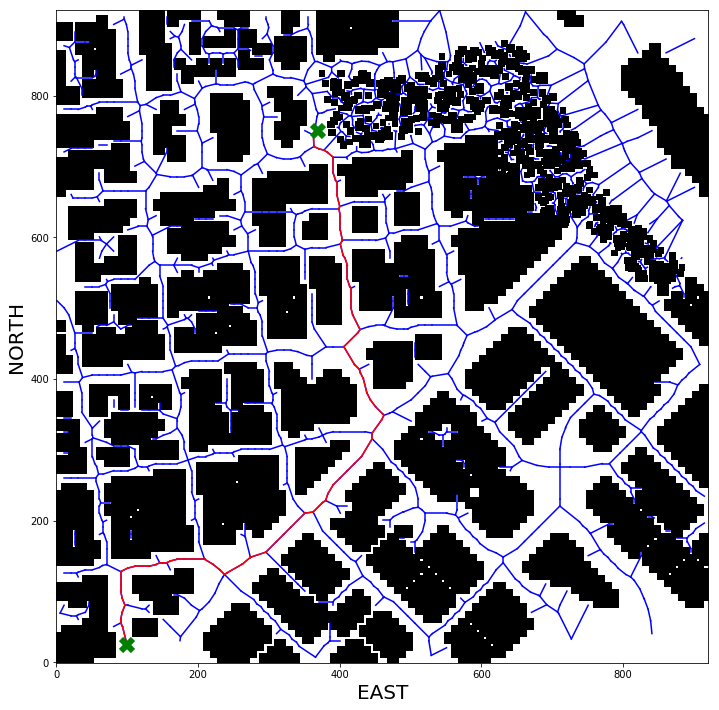

In [9]:
if plot_images:

    plt.imshow(grid, origin='lower', cmap='Greys') 

    for e in edges:
        p1 = e[0]
        p2 = e[1]
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
        
    plt.plot([start_exact[1], start_node[1]], [start_exact[0], start_node[0]], 'r-')
    for i in range(len(path)-1):
        p1 = path[i]
        p2 = path[i+1]
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'r-')
    plt.plot([goal_exact[1], goal_node[1]], [goal_exact[0], goal_node[0]], 'r-')
        
    plt.plot(start_exact[1], start_exact[0], 'gx', markeredgewidth=6, markersize=12)
    plt.plot(goal_exact[1], goal_exact[0], 'gx', markeredgewidth=6, markersize=12)

    plt.xlabel('EAST', fontsize=20)
    plt.ylabel('NORTH', fontsize=20)
    plt.show()

In [10]:
## Prune the path

eps = 10000
hit = True
pruned_path = []
max_dist = 0.0
while hit == True:
    pruned_path = prune_path(path, epsilon = eps)
    for i in range(len(pruned_path) - 1):
        p1 = pruned_path[i]
        p2 = pruned_path[i+1]
        hit = check_edge(p1, p2, grid)
        if hit:
            break

        edge_dist = np.linalg.norm(np.array(p1) - np.array(p2))
        #print(edge_dist)
        if hit == False and edge_dist > max_dist:
            max_dist = edge_dist
    eps *= 0.5

print('path length after pruning: {}'.format(len(pruned_path)))
print('max edge distance: {}'.format(max_dist))
#print(pruned_path)

path length after pruning: 11
max edge distance: 223.93739863163475


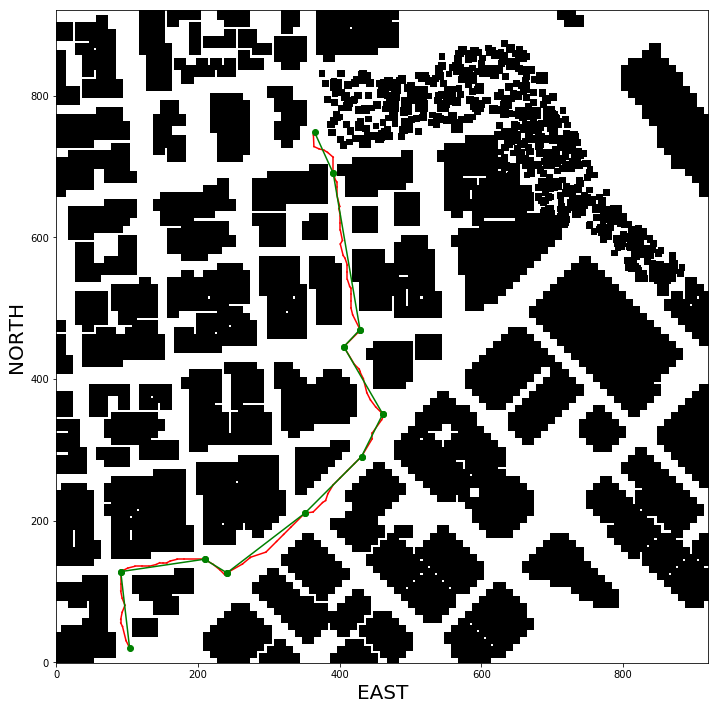

In [11]:
if plot_images:

    plt.imshow(grid, origin='lower', cmap='Greys') 

    for i in range(len(path)-1):
        p1 = path[i]
        p2 = path[i+1]
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'r-')

    for i in range(len(pruned_path)-1):
        p1 = pruned_path[i]
        p2 = pruned_path[i+1]
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'go-' )

    plt.xlabel('EAST', fontsize=20)
    plt.ylabel('NORTH', fontsize=20)
    plt.show()

## 4. Choose a location along the plan and discretize a local volume around that location (a 40x40 m area that is 10 m high discretized into 1m^3 voxels)

(921, 921)
(50, 50)


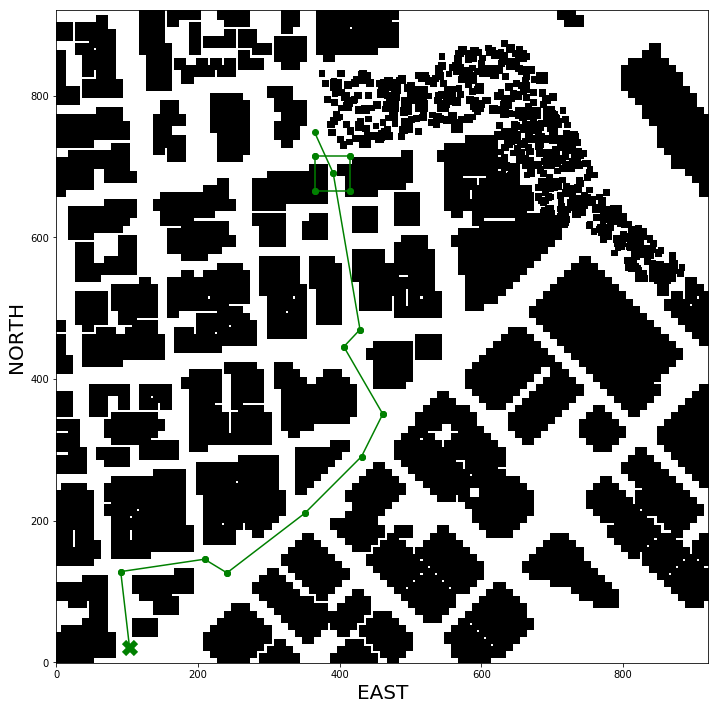

In [12]:
print(grid.shape)
start_pt_number = -2
pt = pruned_path[start_pt_number]
pt = (int(pt[0]), int(pt[1])) 
sub_region_size = 50
subgrid = grid[pt[1] - sub_region_size//2:pt[1] + sub_region_size//2, pt[0] - sub_region_size//2:pt[0] + sub_region_size//2]
print(subgrid.shape)


if plot_images:
    plt.imshow(grid, origin='lower', cmap='Greys') 

    plt.plot([pt[1] - sub_region_size//2, pt[1] + sub_region_size//2], [pt[0] - sub_region_size//2, pt[0] - sub_region_size//2], 'go-')
    plt.plot([pt[1] + sub_region_size//2, pt[1] + sub_region_size//2], [pt[0] - sub_region_size//2, pt[0] + sub_region_size//2], 'go-')
    plt.plot([pt[1] + sub_region_size//2, pt[1] - sub_region_size//2], [pt[0] + sub_region_size//2, pt[0] + sub_region_size//2], 'go-')
    plt.plot([pt[1] - sub_region_size//2, pt[1] - sub_region_size//2], [pt[0] + sub_region_size//2, pt[0] - sub_region_size//2], 'go-')

    plt.plot(start_node[1], start_node[0], 'gx', markeredgewidth=6, markersize=12)

    for i in range(len(pruned_path)-1):
        p1 = pruned_path[i]
        p2 = pruned_path[i+1]
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'go-' )


    plt.xlabel('EAST', fontsize=20)
    plt.ylabel('NORTH', fontsize=20)
    plt.show()



In [13]:
voxel_size = 1

voxmap = create_voxmap_around_point(data, (pt[1],pt[0]), region_size=sub_region_size, voxel_size=voxel_size, alt_max=25)
print(voxmap.shape)

running voxmap around point
(50, 50, 25)


In [14]:
start_pt = pt
print('current pt (y,x) = ({}, {})'.format(start_pt[0], start_pt[1]))
print('next pt (y,x) = ({:.2f}, {:.2f})'.format(start_pt[0], start_pt[1]))
start_wp_voxel = [int(start_pt[0] - start_pt[0] + sub_region_size/2) // voxel_size,
                    int(start_pt[1] - start_pt[1] + sub_region_size/2) // voxel_size,
                    int(flight_altitude) // voxel_size]

next_pt = pruned_path[start_pt_number + 1]
next_wp_voxel = [int(next_pt[0] - start_pt[0] + sub_region_size/2) // voxel_size,
                    int(next_pt[1] - start_pt[1] + sub_region_size/2) // voxel_size,
                    int(flight_altitude) // voxel_size]

dist = np.linalg.norm(np.array(next_wp_voxel) - np.array(start_wp_voxel))
if dist > 0.9 * sub_region_size //2:
    u = (np.array(next_wp_voxel) - np.array(start_wp_voxel))/dist
    next_wp_voxel = np.array(start_wp_voxel) + (0.9 * sub_region_size //2) * u
    next_wp_voxel = list(next_wp_voxel.astype(int))

print('start voxel: {}'.format(start_wp_voxel))
print('goal voxel: {}'.format(next_wp_voxel))
print('dist to goal: {}'.format(dist))

current pt (y,x) = (690, 390)
next pt (y,x) = (690.00, 390.00)
start voxel: [25, 25, 3]
goal voxel: [45, 16, 3]
dist to goal: 63.15853069855251


In [15]:
from vox_sampling import vox_sample

samples = vox_sample(n_samples=10, voxmap=voxmap)

In [16]:
from bresenham3d import bresenhamline
path_local = bresenhamline(np.array([start_wp_voxel]), np.array([next_wp_voxel]), max_iter=-1)
#print(path_local)


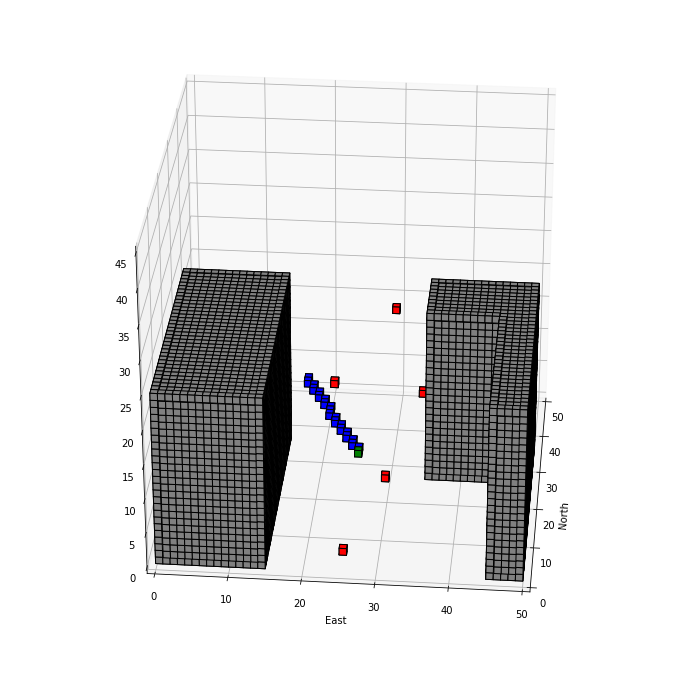

In [17]:
if plot_images:

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    colors = np.empty(voxmap.shape, dtype=object)
    colors[voxmap] = 'gray'

    voxmap_n = np.copy(voxmap)

    for voxel in [start_wp_voxel, next_wp_voxel]:
        voxmap_n[voxel[0], voxel[1], voxel[2]] = True
        colors[voxel[0], voxel[1], voxel[2]] = 'green'

    for voxel in path_local:
        voxmap_n[voxel[0], voxel[1], voxel[2]] = True
        colors[voxel[0], voxel[1], voxel[2]] = 'blue'

    for voxel in samples:
        voxmap_n[voxel[0], voxel[1], voxel[2]] = True
        colors[voxel[0], voxel[1], voxel[2]] = 'red'

    ax.voxels(voxmap_n, facecolors = colors, edgecolor='k')
    ax.set_xlim(voxmap_n.shape[0], 0)
    ax.set_ylim(0, voxmap_n.shape[1])
    # add a bit to z-axis height for visualization
    ax.set_zlim(0, voxmap_n.shape[2]+20)
    ax.view_init(30,5)


    plt.xlabel('North')
    plt.ylabel('East')

    plt.show()

In [18]:
from grid import create_edges_3d

local_nodes = samples
local_nodes.append(tuple(start_wp_voxel))
local_nodes.append(tuple(next_wp_voxel))
#print(samples)
#print(local_nodes)

edges = create_edges_3d(voxmap, local_nodes)

print(edges)



[((1, 25, 2), (10, 30, 8)), ((1, 25, 2), (11, 23, 21)), ((1, 25, 2), (26, 34, 12)), ((1, 25, 2), (42, 29, 16)), ((1, 25, 2), (25, 25, 3)), ((1, 25, 2), (45, 16, 3)), ((10, 30, 8), (1, 25, 2)), ((10, 30, 8), (11, 23, 21)), ((10, 30, 8), (26, 34, 12)), ((10, 30, 8), (42, 29, 16)), ((10, 30, 8), (25, 25, 3)), ((10, 30, 8), (45, 16, 3)), ((11, 23, 21), (1, 25, 2)), ((11, 23, 21), (10, 30, 8)), ((11, 23, 21), (26, 34, 12)), ((11, 23, 21), (42, 29, 16)), ((11, 23, 21), (25, 25, 3)), ((11, 23, 21), (45, 16, 3)), ((26, 34, 12), (1, 25, 2)), ((26, 34, 12), (10, 30, 8)), ((26, 34, 12), (11, 23, 21)), ((26, 34, 12), (42, 29, 16)), ((26, 34, 12), (25, 25, 3)), ((26, 34, 12), (45, 16, 3)), ((42, 29, 16), (1, 25, 2)), ((42, 29, 16), (10, 30, 8)), ((42, 29, 16), (11, 23, 21)), ((42, 29, 16), (26, 34, 12)), ((42, 29, 16), (25, 25, 3)), ((42, 29, 16), (45, 16, 3)), ((25, 25, 3), (1, 25, 2)), ((25, 25, 3), (10, 30, 8)), ((25, 25, 3), (11, 23, 21)), ((25, 25, 3), (26, 34, 12)), ((25, 25, 3), (42, 29, 16)

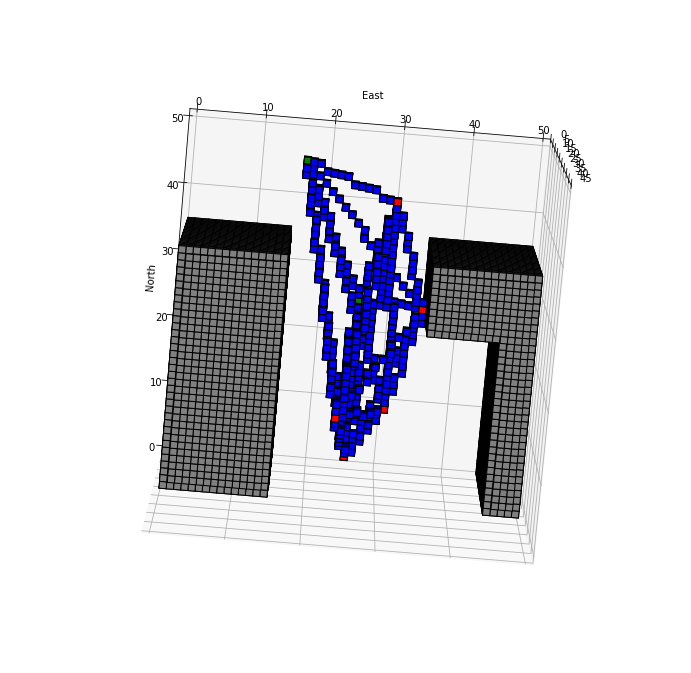

In [25]:
fig = plt.figure()
ax = fig.gca(projection='3d')
colors = np.empty(voxmap.shape, dtype=object)
colors[voxmap] = 'gray'

voxmap_n = np.copy(voxmap)

for edge in edges:
    line = bresenhamline(np.array([edge[1]]), np.array([edge[0]]), max_iter=-1)
    for voxel in line:
        voxmap_n[voxel[0], voxel[1], voxel[2]] = True
        colors[voxel[0], voxel[1], voxel[2]] = 'blue'

for voxel in samples:
    voxmap_n[voxel[0], voxel[1], voxel[2]] = True
    colors[voxel[0], voxel[1], voxel[2]] = 'red'


for voxel in [start_wp_voxel, next_wp_voxel]:
    voxmap_n[voxel[0], voxel[1], voxel[2]] = True
    colors[voxel[0], voxel[1], voxel[2]] = 'green'


ax.voxels(voxmap_n, facecolors = colors, edgecolor='k')
ax.set_xlim(voxmap_n.shape[0], 0)
ax.set_ylim(0, voxmap_n.shape[1])
# add a bit to z-axis height for visualization
ax.set_zlim(0, voxmap_n.shape[2]+20)
ax.view_init(100,5)


plt.xlabel('North')
plt.ylabel('East')

plt.show()

In [30]:
g_local = nx.Graph()
for e in edges:
    p1 = e[0]
    p2 = e[1]
    w = np.linalg.norm(np.array(p2) - np.array(p1))
    g_local.add_edge(p1, p2, weight=w)

print(g[(640.7610999999999, 330.7685)])
print(g_local.nodes)
print(tuple(start_wp_voxel))
print(g_local[tuple(start_wp_voxel)])

{(635.7610999999999, 333.2685): {'weight': 5.5901699437494745}}
[(1, 25, 2), (10, 30, 8), (11, 23, 21), (26, 34, 12), (42, 29, 16), (25, 25, 3), (45, 16, 3)]
(25, 25, 3)
{(1, 25, 2): {'weight': 24.020824298928627}, (10, 30, 8): {'weight': 16.583123951777}, (11, 23, 21): {'weight': 22.891046284519195}, (26, 34, 12): {'weight': 12.767145334803704}, (42, 29, 16): {'weight': 21.77154105707724}, (45, 16, 3): {'weight': 21.93171219946131}}


In [32]:
path, cost = a_star_graph(g_local, heuristic, tuple(start_wp_voxel), tuple(next_wp_voxel))
print('path length: {}    path cost: {}'.format(len(path),cost))
print(path)

Found a path.
path length: 2    path cost: 21.93171219946131
[(25, 25, 3), (45, 16, 3)]
